# Import Libraries and Load Data

In [1]:
import pandas as pd
import geopandas

import matplotlib.pyplot as plt

import custom_functions.joins as j
import custom_functions.clean_strings as cs

Let's import the data. `geopandas.GeoDataFrame` can have as many `geopandas.GeoSeries` objects within, but only one is active at a time.

In [2]:
# load stalls lon-lat table
bikemi_stalls = geopandas.read_file("../data/bikemi_metadata/bikemi_stalls.geojson")

# load NIL lon-lat table
nil = geopandas.read_file("../data/milan/milan_nil.geojson")

# actually not needed, municipi categorical var is already in bikemi_stalls
municipi = geopandas.read_file("../data/milan/milan_municipi.geojson")


In [3]:
# select only the column we need + rename
nil = nil[["ID_NIL", "NIL", "geometry"]] \
    .assign(NIL = lambda x: x["NIL"].str.title()) \
    .astype({"ID_NIL": "category", "NIL": "category"}) \
    .rename(columns={"NIL": "nil", "ID_NIL": "nil_number"}) \
    .set_index("nil_number") \
    .sort_values("nil", ascending = True)

In [4]:
# select only the column we need + rename
bikemi_stalls = bikemi_stalls \
    [["nome", "zd_attuale", "geometry", "anno"]] \
    .rename(columns={"zd_attuale" : "municipio"}) \
    .sort_values(by = ["nome"], ascending = True) \
    .astype({"nome": "category", "municipio": "category"}) \
    .set_index("nome")

In [5]:
bikemi_stalls

,municipio,geometry,anno
nome,,,
Accursio - Portello,8,POINT (9.14589 45.49091),2015.0
Adamello - Lorenzini,5,POINT (9.20310 45.44341),2015.0
Alserio - Cola Montano,9,POINT (9.18568 45.49104),2016.0
Amendola M1,8,POINT (9.15171 45.47364),2015.0
Angilberto - Comacchio,4,POINT (9.21749 45.43721),2018.0
...,...,...,...
XXII Marzo,4,POINT (9.21247 45.46216),2011.0
XXIV Maggio,5,POINT (9.17955 45.45222),2009.0
XXV Aprile,1,POINT (9.18667 45.48017),2008.0


We have geometries. Let's make a first plot, to see how it looks like.

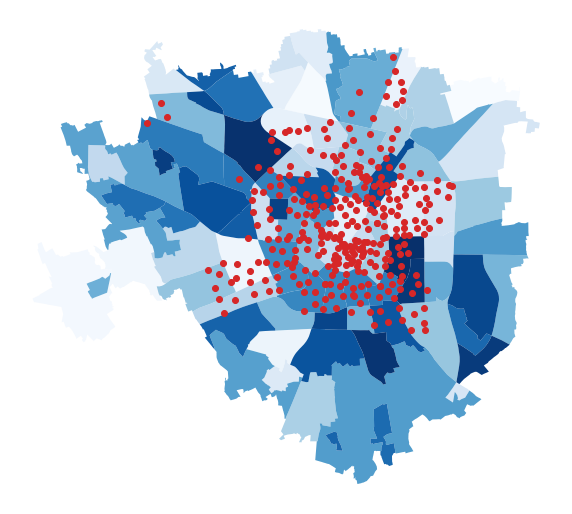

In [6]:
# define ax object and dimensions
fig, ax = plt.subplots(figsize = (10,10))

# plot both objects on the same axes; order matters
nil.plot(ax = ax, cmap = "Blues")
bikemi_stalls.plot(ax = ax, color = "tab:red")

# remove the axis lines
plt.axis("off")
plt.show()

Finally, let's load the time series data:

In [7]:
# load the time series for each station in the long format
station_outflow = pd.read_csv("../data/bikemi_csv/station_daily_outflow.csv", parse_dates=[0], index_col=[0])

station_outflow.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 104589 entries, 2019-12-31 to 2019-01-01
Data columns (total 2 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   stazione_partenza  104589 non-null  object
 1   count              104589 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


# First Join: BikeMi Stalls and Time Series Data

## Tentative Join

In [8]:
# join the index of the table specified as the first argument on the column specified by the "on" argument
tentative_join = geopandas.GeoDataFrame(
    # the data to pass as first argument:
    station_outflow.join(bikemi_stalls, on = "stazione_partenza") \
    .sort_values(["giorno_partenza", "stazione_partenza"], ascending = True),
    # then set the coordinate reference system
    crs = "EPSG:4326"
)

In [9]:
tentative_join.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
DatetimeIndex: 104589 entries, 2019-01-01 to 2019-12-31
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   stazione_partenza  104589 non-null  object  
 1   count              104589 non-null  int64   
 2   municipio          91458 non-null   category
 3   geometry           91458 non-null   geometry
 4   anno               91098 non-null   float64 
dtypes: category(1), float64(1), geometry(1), int64(1), object(1)
memory usage: 4.1+ MB


Some information is actually lost! There are some observations from the dataset which cannot be matched to the stalls list.

In [10]:
unique_stalls = pd.Series(bikemi_stalls.index.unique())
unique_stations = pd.Series(station_outflow["stazione_partenza"].sort_values(ascending=True).unique(), name = "stazione_partenza")

print(f"""
Number of stalls in the official data: {unique_stalls.size}.
Number of stalls in our time series: {unique_stations.size}.
""")


Number of stalls in the official data: 319.
Number of stalls in our time series: 306.



## String Matching

13 stalls are missing, but we are likely to find more mismatches. To deal with this, we have to turn to snake_case all station names, then perform the join again. We will have to use regular expressions. As Jamie Zawinski said in 1997:

> Some people, when confronted with a problem, think: "I know, I'll use regular expressions". Now they have two problems.

Here we apply some custom functions, which can be found in the omonimous folder under this directory.

In [11]:
clean_stalls = cs.clean_series(unique_stalls)
clean_stations = cs.clean_series(unique_stations)

j.mismatches(clean_stalls, clean_stations, left_on = "nome", right_on = "stazione_partenza")
mismatched_stations, mismatched_stalls = j.mismatches(clean_stalls, clean_stations, left_on = "nome", right_on = "stazione_partenza", text = False)



        1 stations are only in the time series data.
        14 stalls are only in the stalls data.
        


In [12]:
list(mismatched_stalls), list(mismatched_stations)

(['brunelleschi_giambellino',
  'cascina_merlata_social_village',
  'cascina_merlata_uptown',
  'ciclamini_palazzetto_del_ghiaccio',
  'fezzan_forli',
  'giambellino_odazio',
  'gioia_vespucci',
  'inganni_corba',
  'inganni_lorenteggio',
  'passerini_belloveso',
  'san_giminiano_solderini',
  'tirana_san_cristoforo',
  'tolstoi_lorenteggio',
  'velasquez_osoppo'],
 ['santagostino'])

Some stations do not appear because they were introduced in 2020 and 2021, i.e. `Brunelleschi - Giambellino`. Others, such as `Gioia - Vespucci`, do not have a value for `anno`.

In [13]:
bikemi_stalls.loc[(bikemi_stalls["anno"] >= 2020) | (bikemi_stalls["anno"].isna())]
# does not work in this case, but:
# bikemi_stalls.loc[bikemi_stalls["anno"].isin([2020,2021])]

,municipio,geometry,anno
nome,,,
Brunelleschi - Giambellino,6,POINT (9.14443 45.44904),2020.0
Cascina Merlata - Social Village,8,POINT (9.10079 45.51169),2021.0
Cascina Merlata - UpTown,8,POINT (9.10345 45.50711),2021.0
Ciclamini - Palazzetto del Ghiaccio,6,POINT (9.12796 45.45558),2020.0
Fezzan - Forli',6,POINT (9.14623 45.45963),2020.0
Giambellino - Odazio,6,POINT (9.13521 45.44717),2020.0
Gioia - Vespucci,9,POINT (9.19167 45.48139),NaN
Inganni - Corba,6,POINT (9.12592 45.45103),2020.0
Inganni - Lorenteggio,6,POINT (9.12791 45.44736),2020.0


This is another reason for aggregating the data to the NIL level: stations may change across this time span, whereas NIL stay the same for 10 years at least.

Now we can retry the join, after applying the custom function for cleaning strings to each column we plan to join.

## Cleaned Data

In [14]:
clean_outflow = cs.clean_df(station_outflow, col = "stazione_partenza", inplace = True)
clean_bikemi_stalls = cs.clean_df(bikemi_stalls.drop("anno", axis = 1).reset_index(), col = "nome", inplace = True).set_index("nome")

In [15]:
geo_outflow = geopandas.GeoDataFrame(
    clean_outflow.join(clean_bikemi_stalls, on = "stazione_partenza").iloc[::-1],
    crs = "EPSG:4326"
)

In [16]:
geo_outflow.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
DatetimeIndex: 104589 entries, 2019-01-01 to 2019-12-31
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   stazione_partenza  104589 non-null  object  
 1   count              104589 non-null  int64   
 2   municipio          104379 non-null  category
 3   geometry           104379 non-null  geometry
dtypes: category(1), geometry(1), int64(1), object(1)
memory usage: 3.3+ MB


Notice that we lose just a small part of the observations. Now it's finally time to perform the spatial joins to obtain the NIL from this data:

# Two Spatial Joins

Let's proceed with a spatial operation, to assign each stall to its NIL, i.e. neighbourhood. The spatial operations can be:

* `intersects`: if the object on the left is inside or on the boundary of the object on the right.
* `contains`: if the object on the left contains the one on the right (i.e. no part of right is outside of left).
* `within`: the opposite of `contains`.
* `touches`: if boundaries touch in at least one point, but none in the interior.
* `crosses`: more than one but not all points in common.
* `overlaps`: same as above, but the objects have the same dimension and yet do not coincide (see it as equivalence vs congruence).

## Second Spatial Join: Georeferenced Time Series and Local Neighbourhoods (NIL)

In [17]:
geo_outflow_nil = geopandas.sjoin(geo_outflow, nil, how="inner", op = "intersects")

In [18]:
geo_outflow_nil = geo_outflow_nil.rename(columns = {"geometry": "nil_geometry", "index_right" : "nil_number", "nil": "nil_name"}).set_geometry("nil_geometry")

geo_outflow_nil.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
DatetimeIndex: 104379 entries, 2019-01-01 to 2019-12-31
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   stazione_partenza  104379 non-null  object  
 1   count              104379 non-null  int64   
 2   municipio          104379 non-null  category
 3   nil_geometry       104379 non-null  geometry
 4   nil_number         104379 non-null  category
 5   nil_name           104379 non-null  category
dtypes: category(3), geometry(1), int64(1), object(1)
memory usage: 3.5+ MB


In [19]:
geo_outflow_nil.head()

,stazione_partenza,count,municipio,nil_geometry,nil_number,nil_name
giorno_partenza,,,,,,
2019-01-01,accursio_portello,2,8,POINT (9.14589 45.49091),71,Villapizzone - Cagnola - Boldinasco
2019-01-01,mac_mahon_artieri,2,8,POINT (9.15498 45.49588),71,Villapizzone - Cagnola - Boldinasco
2019-01-02,accursio_portello,10,8,POINT (9.14589 45.49091),71,Villapizzone - Cagnola - Boldinasco
2019-01-02,castelli_ailanti,2,8,POINT (9.15210 45.49945),71,Villapizzone - Cagnola - Boldinasco
2019-01-02,mac_mahon_artieri,6,8,POINT (9.15498 45.49588),71,Villapizzone - Cagnola - Boldinasco


Let's see how many NILs actually end up in the data:

In [20]:
geo_outflow_nil.nil_name.unique()

['Villapizzone - Cagnola - Boldinasco', 'Scalo Romana', 'Isola', 'De Angeli - Monte Rosa', 'Lodi - Corvetto', ..., 'Q.Re Gallaratese - Q.Re San Leonardo - Lampug..., 'Ortomercato', 'Lorenteggio', 'Umbria - Molise - Calvairate', 'Bande Nere']
Length: 42
Categories (88, object): ['Adriano', 'Affori', 'Assiano', 'Baggio - Q.Re Degli Olmi - Q.Re Valsesia', ..., 'Umbria - Molise - Calvairate', 'Vigentino - Q.Re Fatima', 'Villapizzone - Cagnola - Boldinasco', 'Xxii Marzo']

Basically, there are bikemi stations in only half of the NILs in Milan.

Let's aggregate the data at the `nil` level, i.e. see how many rentals are made each day in a given area.

In [26]:
nil_aggregated_outflow = geo_outflow_nil.reset_index().groupby(["nil_name", "giorno_partenza"]).sum().reset_index().set_index("giorno_partenza")

## Appendix: Join with Municipi Data

Finally, we might want to have preserved the `municipio` information:

In [22]:
nil_municipi = geopandas.sjoin(nil, municipi, how = "inner", op = "intersects")

In [23]:
nil_municipi.head()

,nil,geometry,index_right,OBJECTID,MUNICIPIO,AREA,PERIMETRO,Shape_Length,Shape_Area
nil_number,,,,,,,,,
17,Adriano,"POLYGON ((9.26729 45.51234, 9.26730 45.51236, ...",3,4,2,1.262855e+07,20971.2966,29934.120124,2.572649e+07
15,Bicocca,"POLYGON ((9.22259 45.52361, 9.22253 45.52363, ...",3,4,2,1.262855e+07,20971.2966,29934.120124,2.572649e+07
21,Buenos Aires - Porta Venezia - Porta Monforte,"POLYGON ((9.22356 45.48603, 9.22261 45.48603, ...",3,4,2,1.262855e+07,20971.2966,29934.120124,2.572649e+07
18,Cimiano - Rottole - Q.Re Feltre,"POLYGON ((9.26860 45.51035, 9.26833 45.51037, ...",3,4,2,1.262855e+07,20971.2966,29934.120124,2.572649e+07
16,Gorla - Precotto,"POLYGON ((9.23591 45.51747, 9.23587 45.51759, ...",3,4,2,1.262855e+07,20971.2966,29934.120124,2.572649e+07


In [24]:
nil_municipi = nil_municipi[["nil", "MUNICIPIO", "geometry"]].rename(columns= {"nil": "nil_name", "MUNICIPIO": "municipio", "geometry": "geometry_municipio"})\
    .join(nil).reset_index().rename(columns={"geometry": "geometry_nil"}).drop("nil", axis = 1)

The shape of the dataframe tells us that some `NIL` actually end un in multiple `Municipi`: for example, Brera spans across three!

# Save the Final Dataset

In [27]:
nil_aggregated_outflow.to_csv("../data/bikemi_csv/nil_daily_outflow.csv")